## GRU model testing
OK, we have done carry forward control, we have done simple linear models, we have done ARIMA - last thing to try before going on a data hunt in true neural network based models. We could try some regression with vanilla dense layers or something, but I think we should cut to the chase and go straight to a GRU based network. Let's get a minimal example set up to get an idea of what we are working with and then set up a more rigorous hyperparameter optimization with crossvalidation/bootstrapping.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda/'

import shelve
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

# Add notebook parent dir to path so we can import from functions/
import sys
sys.path.append('..')

# Import project config file
import config as conf

# Import notebooks specific helper functions
import functions.notebook_helper_functions.notebook15 as funcs

# Instantiate paths and model parameters
paths = conf.DataFilePaths()
params = conf.GRU_model_parameters()

# Load data column index
index = shelve.open(paths.PARSED_DATA_COLUMN_INDEX)

In [2]:
# Load data with block size
input_file = f'{paths.PARSED_DATA_PATH}/{params.input_file_root_name}{params.block_size}.npy'
timepoints = np.load(input_file)

OK, so here we go. Hardest part about working with this type of model is getting the data into the correct shape for input. Couple of considerations here:
1. Do training/validation split where data is kept in sequential time order with older data being used for training and newer data being used for validation.
2. Start with only one input feature - the microbusiness density (or detrended microbusiness density).
3. Forecast one point into the future.
4. Be ready to standardize/unstandardize data using statistics from the training set only.
5. Input data is formatted as (batch, timesteps, feature). 

The last part is a little complicated to think about - we have > 3k timeseries with the same time axis, one for each county. We could treat this like 3k features, but I think the better idea is to think of it as one feature and 3k counties * 37 timepoints input datapoints. The trick is, how do we batch/make timesteps out of it? We don't want to present the model timeseries from different counties as if one comes after the next. I think the most obvious way to do this is use a stateless GRU layer and then present each county as a batch. Within that batch we then have the block from our sliding window data parse.

Ok, I think that sounds like as good a place to start as any. Let's take a look at the data:

In [3]:
# Load data with block size
input_file = f'{paths.PARSED_DATA_PATH}/{params.input_file_root_name}{params.block_size}.npy'
timepoints = np.load(input_file)

# Print so info
print()
print(f'Input data shape: {timepoints.shape}')
print()

print('Input data column index:')

for column, num in index.items():
    print(f'{column}: {num}')


Input data shape: (27, 3135, 13, 6)

Input data column index:
cfips: 0
first_day_of_month: 1
microbusiness_density: 2
active: 3
microbusiness_density_change: 4
microbusiness_density_change_change: 5


The dimensions here are:

0. The timepoint block - the sized of this axis depends on the width of the block used to scan the data - smaller blocks give more timepoints with num_timepoint_blocks = total_timepoints - block_size + 1. This is also the axis we need to do our training validation split on. First part becomes training, last part becomes validation.
1. The counties - each element here is a county, for the purposes of our first experiment with this we will treat each county as a batch.
2. The the timepoints in the timepoint block (~row in pandas dataframe).
3. The features (~column in pandas dataframe). To start with, we will work with one feature only - the microbusiness density.

First up - training/validation split:

In [4]:
# Before we split, choose just the data we want and drop everything else
if params.num_counties == 'all':
    input_data = timepoints[:,:,:,[index[params.input_data_type]]]
else:
    input_data = timepoints[:,:params.num_counties,:,[index[params.input_data_type]]]

# Reserve last n timepoints for true hold-out test set
testing_data = input_data[-params.test_timepoints:,:,:,:]
input_data = input_data[:-params.test_timepoints,:,:,:]

# Choose split
split_index = int(input_data.shape[0] * params.training_split_fraction)

# Split data into training and validation sets using chosen index. First 
# #portion becomes training, second portion is validation
training_data = input_data[0:split_index]
validation_data = input_data[split_index:-1]

print(f'Input data shape: {input_data.shape}')
print(f'Testing timepoints: {params.test_timepoints}')
print(f'Split fraction: {params.training_split_fraction}')
print(f'Split index: {split_index}')
print(f'Training data shape: {training_data.shape}')
print(f'Validation data shape: {validation_data.shape}')
print(f'Testing data shape: {testing_data.shape}')

Input data shape: (26, 3135, 13, 1)
Testing timepoints: 1
Split fraction: 0.7
Split index: 18
Training data shape: (18, 3135, 13, 1)
Validation data shape: (7, 3135, 13, 1)
Testing data shape: (1, 3135, 13, 1)


OK, looks good - let's try converting everything to a z-score, using the mean and standard deviation from the training sample only.

In [5]:
# Get mean and standard deviation from training data
training_mean = np.mean(training_data)
training_deviation = np.std(training_data)

print(f'Mean: {training_mean:.2f}, standard deviation: {training_deviation:.2f}')

# Standardize the training, validation and test data
training_data = (training_data - training_mean) / training_deviation
validation_data = (validation_data - training_mean) / training_deviation
testing_data = (testing_data - training_mean) / training_deviation

print(f'Training data, new mean: {np.mean(training_data):.2f}, new standard deviation: {np.std(training_data):.2f}')
print(f'Validation data, new mean: {np.mean(validation_data):.2f}, new standard deviation: {np.std(validation_data):.2f}')
print(f'Testing data, new mean: {np.mean(testing_data):.2f}, new standard deviation: {np.std(testing_data):.2f}')

Mean: 3.78, standard deviation: 4.62
Training data, new mean: 0.00, new standard deviation: 1.00
Validation data, new mean: 0.03, new standard deviation: 1.26
Testing data, new mean: 0.04, new standard deviation: 1.27


In [6]:
# Swap first and second axis to make the data batch major, instead of time 
# major - this is the more common format for tensorflow and what our GRU 
# layer(s) will expect to see
training_data = np.swapaxes(training_data, 1, 0)
validation_data = np.swapaxes(validation_data, 1, 0)
testing_data = np.swapaxes(testing_data, 1, 0)

print(f'New training data shape: {training_data.shape}')
print(f'New validation data shape: {validation_data.shape}')
print(f'New testing data shape: {testing_data.shape}')

New training data shape: (3135, 18, 13, 1)
New validation data shape: (3135, 7, 13, 1)
New testing data shape: (3135, 1, 13, 1)


Looks good! Let's build the model. Only additional thing to mention here is that for each time block in the counties, the first n - 5 datapoints are the time ordered input and the last five is the value we are trying to predict. With that in mind, let's go!

In [7]:
def build_GRU(
    GRU_units: int = 64,
    learning_rate: float = 0.0002,
    input_shape: list[int] = [13,8,1],
    output_units: int = 5
):
    '''Builds GRU based neural network for
    microbusiness density regression'''

    # Input layer
    input = layers.Input(
        name = 'Input',
        shape = input_shape
    )

    # GRU layer
    gru = layers.GRU(
        GRU_units,
        activation='tanh',
        recurrent_activation='sigmoid',
        use_bias=True,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal',
        bias_initializer='zeros',
        kernel_regularizer=None,
        recurrent_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        recurrent_constraint=None,
        bias_constraint=None,
        dropout=0.0,
        recurrent_dropout=0.0,
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False,
        reset_after=True,
        name='GRU'
    )(input)

    # output layer
    output = layers.Dense(
        name = 'Output',
        units = output_units,
        activation = 'linear'
    )(gru)

    # Next, we will build the complete model and compile it.
    model = keras.models.Model(
        input, 
        output,
        name = 'Simple_GRU_model'
    )

    model.compile(
        loss = keras.losses.MeanSquaredError(name = 'MSE'), 
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
        metrics = [keras.metrics.MeanAbsoluteError(name = 'MAE')]
    )

    print(model.summary())

    return model

In [8]:
def data_generator(data):
    '''Generates pairs of X, Y (input, target) datapoints
    from batch major data'''
    
    # Don't stop
    while True:
        # Loop on counties
        for i in range(data.shape[0]):
                
            X = data[i,:,:-params.forecast_horizon,:]
            Y = data[i,:,-params.forecast_horizon:,:]

            yield (X, Y)

In [9]:
# Start generators and grab a sample data points to
# derive network parameters
training_data_generator = data_generator(training_data)
training_sample = next(training_data_generator)

validation_data_generator = data_generator(validation_data)
validation_sample = next(validation_data_generator)

# Run parameters
output_units = training_sample[1].shape[1]
training_batch_size = training_data.shape[1]
training_batches = training_data.shape[0]
validation_batch_size = validation_data.shape[1]
validation_batches = validation_data.shape[0]

# Check dataset's overall shape
print()
print('####### DATA SHAPE #######')
print()
print(f'Training dataset: {training_data.shape}')
print(f'Validation dataset: {validation_data.shape}')
print()
print(f'Training input: {training_sample[0].shape}')
print(f'Training target: {training_sample[1].shape}')
print()
print(f'Validation input: {validation_sample[0].shape}')
print(f'Validation target: {validation_sample[1].shape}')

# Check run parameters
print()
print('####### RUN PARAMETERS #######')
print()
print(f'Epochs: {params.epochs}')
print(f'Training batch size: {training_batch_size}')
print(f'Training batches: {training_batches}')
print(f'Validation batch size: {validation_batch_size}')
print(f'Validation batches: {validation_batches}')
print()

# Build the model
model = build_GRU(
    GRU_units = params.GRU_units,
    learning_rate = params.learning_rate,
    input_shape = [training_sample[0].shape[1],training_sample[0].shape[2]],
    output_units = output_units
)

# Re-fire data generators for training and validation
training_data_generator = data_generator(training_data)
validation_data_generator = data_generator(validation_data)

# Train the model
history = model.fit(
    training_data_generator,
    epochs = params.epochs,
    batch_size = training_batch_size,
    steps_per_epoch = training_batches,
    validation_data = validation_data_generator,
    validation_batch_size = validation_batch_size,
    validation_steps = validation_batches
)


####### DATA SHAPE #######

Training dataset: (3135, 18, 13, 1)
Validation dataset: (3135, 7, 13, 1)

Training input: (18, 8, 1)
Training target: (18, 5, 1)

Validation input: (7, 8, 1)
Validation target: (7, 5, 1)

####### RUN PARAMETERS #######

Epochs: 25
Training batch size: 18
Training batches: 3135
Validation batch size: 7
Validation batches: 3135

Model: "Simple_GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 8, 1)]            0         
                                                                 
 GRU (GRU)                   (None, 32)                3360      
                                                                 
 Output (Dense)              (None, 5)                 165       
                                                                 
Total params: 3,525
Trainable params: 3,525
Non-trainable params: 0
____________________

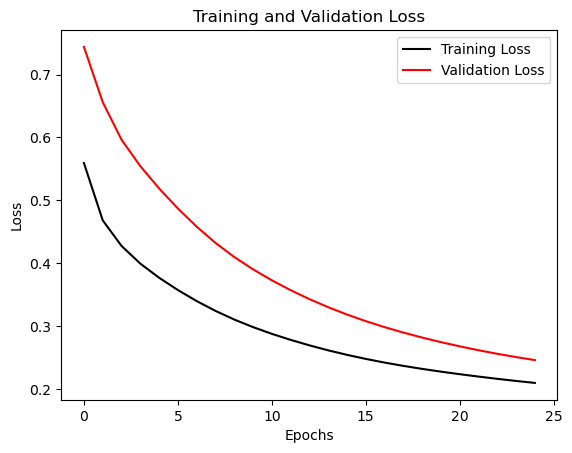

In [10]:
# Plot and label the training and validation loss values
plt.plot(list(range(len(history.history['loss']))), history.history['loss'], c='black', label='Training Loss')
plt.plot(list(range(len(history.history['val_loss']))), history.history['val_loss'], c='red', label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [11]:
# Fire up generators
validation_data_generator = data_generator(validation_data)
training_data_generator = data_generator(training_data)

# Predict from validation
validation_predictions = model.predict(
    validation_data_generator,
    batch_size = validation_batch_size,
    steps = validation_batches
)

# Predict from training
training_predictions = model.predict(
    training_data_generator,
    batch_size = training_batch_size,
    steps = training_batches
)

# Get targets
validation_targets = validation_data[:,:,-params.forecast_horizon:,:]
training_targets = training_data[:,:,-params.forecast_horizon:,:]

# Unstandardize everything
training_predictions = (training_predictions * training_deviation) + training_mean
validation_predictions = (validation_predictions * training_deviation) + training_mean
training_targets = (training_targets * training_deviation) + training_mean
validation_targets = (validation_targets * training_deviation) + training_mean

print()
print(f'Validation dataset: {validation_data.shape}')
print()
print(f'Validation targets: {validation_targets.shape}')
print(f'Validation predictions: {validation_predictions.shape}')

# Flatten everything
flattened_validation_predictions = validation_predictions.flatten()
flattened_training_predictions = training_predictions.flatten()
flattened_validation_targets = validation_targets.flatten()
flattened_training_targets = training_targets.flatten()

print()
print(f'Flattened validation targets: {flattened_validation_targets.shape}')
print(f'Flattened validation predictions: {flattened_validation_predictions.shape}')

3135/3135 [==============================] - 7s 2ms/step

Validation dataset: (3135, 7, 13, 1)

Validation targets: (3135, 7, 5, 1)
Validation predictions: (21945, 5)

Flattened validation targets: (109725,)
Flattened validation predictions: (109725,)


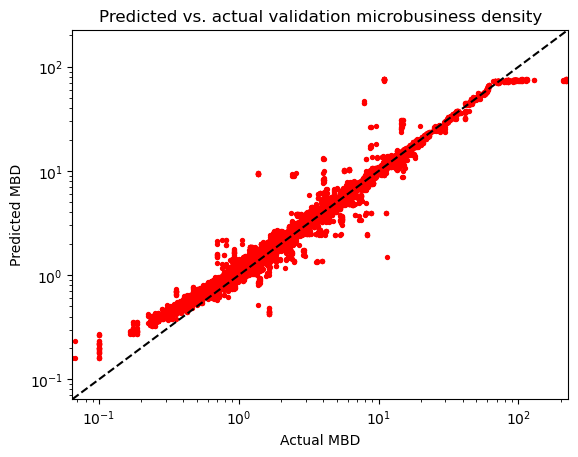

In [12]:
# Plot predicted vs actual MBD values for validation set
point_size = 8
plt.scatter(flattened_validation_targets, flattened_validation_predictions, s=point_size, c='red')

# Set common axis limits
data_pool = list(flattened_validation_targets) + list(flattened_validation_predictions)
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual validation microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
#plt.legend(loc='best')
plt.show()

In [13]:
# Split off the last three individual month's predictions
# this approximates the final private leaderboard scoring
index_3_validation_predictions = validation_predictions[:,2]
index_4_validation_predictions = validation_predictions[:,3]
index_5_validation_predictions = validation_predictions[:,4]

index_3_validation_targets = validation_targets[:,:,2].flatten()
index_4_validation_targets = validation_targets[:,:,3].flatten()
index_5_validation_targets = validation_targets[:,:,4].flatten()

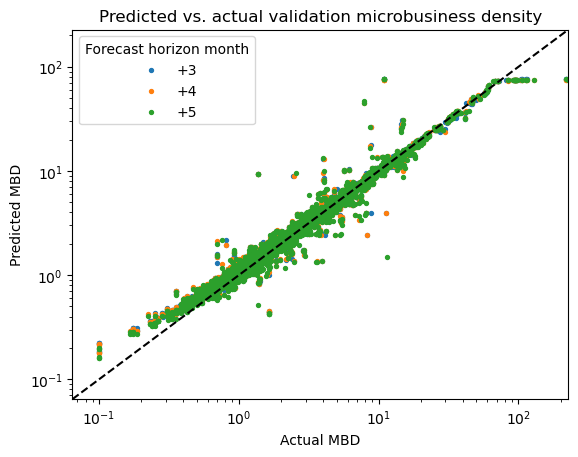

In [14]:
# Plot predicted vs actual MBD values for validation set by the forecast horizon index
point_size = 8
plt.scatter(index_3_validation_targets, index_3_validation_predictions, s=point_size, label='+3')
plt.scatter(index_4_validation_targets, index_4_validation_predictions, s=point_size, label='+4')
plt.scatter(index_5_validation_targets, index_5_validation_predictions, s=point_size, label='+5')

# Set common axis limits
data_pool = list(flattened_validation_targets) + list(flattened_validation_predictions)
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual validation microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
plt.legend(title='Forecast horizon month', loc='best')
plt.show()

In [15]:
# Fire up generator
testing_data_generator = data_generator(testing_data)

# Predict from testing
testing_predictions = model.predict(
    testing_data_generator,
    batch_size = testing_data.shape[1],
    steps = testing_data.shape[0]
)

# Get targets
testing_targets = testing_data[:,:,-params.forecast_horizon:,:]

# Unstandardize everything
testing_predictions = (testing_predictions * training_deviation) + training_mean
testing_targets = (testing_targets * training_deviation) + training_mean

print()
print(f'Testing dataset: {testing_data.shape}')
print()
print(f'Testing targets: {testing_targets.shape}')
print(f'Testing predictions: {testing_predictions.shape}')

# Flatten everything
flattened_testing_predictions = testing_predictions.flatten()
flattened_testing_targets = testing_targets.flatten()

print()
print(f'Flattened testing targets: {flattened_testing_targets.shape}')
print(f'Flattened testing predictions: {flattened_testing_predictions.shape}')

3135/3135 [==============================] - 7s 2ms/step

Testing dataset: (3135, 1, 13, 1)

Testing targets: (3135, 1, 5, 1)
Testing predictions: (3135, 5)

Flattened testing targets: (15675,)
Flattened testing predictions: (15675,)


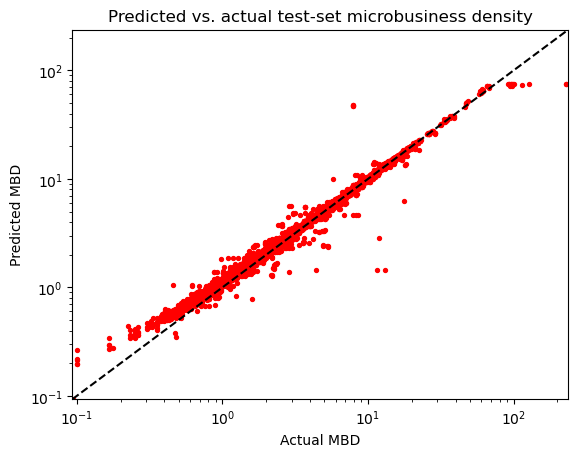

In [16]:
# Plot predicted vs actual MBD values for testing set
point_size = 8
plt.scatter(flattened_testing_targets, flattened_testing_predictions, s=point_size, c='red')

# Set common axis limits
data_pool = list(flattened_testing_targets) + list(flattened_testing_predictions)
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual test-set microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
plt.show()

In [17]:
# Split off the last three individual month's predictions
# this approximates the final private leaderboard scoring
index_3_testing_predictions = testing_predictions[:,2]
index_4_testing_predictions = testing_predictions[:,3]
index_5_testing_predictions = testing_predictions[:,4]

index_3_testing_targets = testing_targets[:,:,2].flatten()
index_4_testing_targets = testing_targets[:,:,3].flatten()
index_5_testing_targets = testing_targets[:,:,4].flatten()

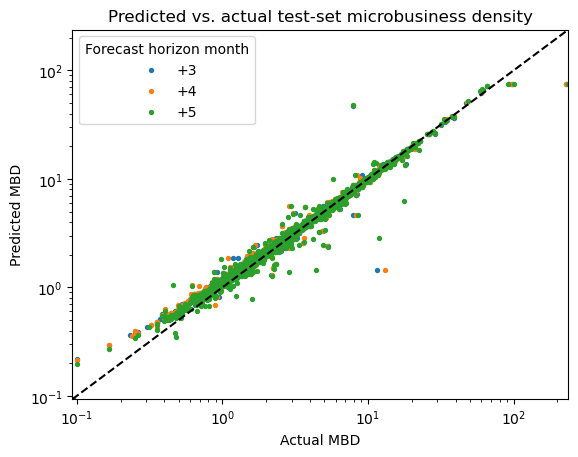

In [18]:
# Plot predicted vs actual MBD values for testing set by the forecast horizon index
point_size = 8
plt.scatter(index_3_testing_targets, index_3_testing_predictions, s=point_size, label='+3')
plt.scatter(index_4_testing_targets, index_4_testing_predictions, s=point_size, label='+4')
plt.scatter(index_5_testing_targets, index_5_testing_predictions, s=point_size, label='+5')

# Set common axis limits
data_pool = list(flattened_testing_targets) + list(flattened_testing_predictions)
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual test-set microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
plt.legend(title='Forecast horizon month', loc='best')
plt.show()